In [10]:
import xpress as xp
from xpress import constants   # needed for solver status constants

# -------------------------------------------------------------------
# User-defined parameters (adjust as needed)
# -------------------------------------------------------------------
num_gateway   = 8      # total number of gateway courses (must be Cg * |S| = 4*2)
num_optional  = 4      # total number of optional courses (must be Co * |S| = 2*2)
num_days      = 5      # e.g., Monday to Friday
num_hours     = 9      # e.g., 9 am – 5 pm

# Teaching requirements
RgL = 3   # lectures per gateway course
RgW = 1   # weekly workshops per gateway course
RgF = 1   # fortnightly workshops per gateway course
RoL = 3   # lectures per optional course
RoW = 1   # weekly workshops per optional course

# Courses per semester
Cg = 4    # gateway courses per semester
Co = 2    # optional courses per semester

# -------------------------------------------------------------------
# Sets (using 0‑based indices for programming convenience)
# -------------------------------------------------------------------
G = range(num_gateway)          # gateway courses
O = range(num_optional)         # optional courses
S = [1, 2]                      # semesters
D = range(num_days)             # teaching days
H = range(num_hours)            # teaching hours
W = [1, 2]                      # week parity (1 = odd, 2 = even)

In [17]:

# -------------------------------------------------------------------
# Create the Xpress problem
# -------------------------------------------------------------------
m = xp.problem("timetabling")

# -------------------------------------------------------------------
# Decision variables (all binary)
# -------------------------------------------------------------------
xL = {(g, d, h, s): xp.var(vartype=xp.binary)
      for g in G for d in D for h in H for s in S}
xW = {(g, d, h, s): xp.var(vartype=xp.binary)
      for g in G for d in D for h in H for s in S}
xF = {(g, d, h, s, w): xp.var(vartype=xp.binary)
      for g in G for d in D for h in H for s in S for w in W}
yL = {(o, d, h, s): xp.var(vartype=xp.binary)
      for o in O for d in D for h in H for s in S}
yW = {(o, d, h, s): xp.var(vartype=xp.binary)
      for o in O for d in D for h in H for s in S}
z  = {(g, s): xp.var(vartype=xp.binary) for g in G for s in S}
w  = {(o, s): xp.var(vartype=xp.binary) for o in O for s in S}

# Add all variables to the model
# Collect all variables into a single flat list
all_vars = (list(xL.values()) + list(xW.values()) + list(xF.values()) +
            list(yL.values()) + list(yW.values()) + list(z.values()) + list(w.values()))

# Add all variables to the model at once
m.addVariable(all_vars)
# -------------------------------------------------------------------
# Constraints
# -------------------------------------------------------------------

# 1. Each course runs in exactly one semester
for g in G:
    m.addConstraint(xp.Sum(z[g, s] for s in S) == 1)
for o in O:
    m.addConstraint(xp.Sum(w[o, s] for s in S) == 1)

# 2. Exactly Cg gateway courses and Co optional courses per semester
for s in S:
    m.addConstraint(xp.Sum(z[g, s] for g in G) == Cg)
    m.addConstraint(xp.Sum(w[o, s] for o in O) == Co)

# 3. Correct number of weekly teaching events per course per semester
for g in G:
    for s in S:
        m.addConstraint(xp.Sum(xL[g, d, h, s] for d in D for h in H) == RgL * z[g, s])
        m.addConstraint(xp.Sum(xW[g, d, h, s] for d in D for h in H) == RgW * z[g, s])
for o in O:
    for s in S:
        m.addConstraint(xp.Sum(yL[o, d, h, s] for d in D for h in H) == RoL * w[o, s])
        m.addConstraint(xp.Sum(yW[o, d, h, s] for d in D for h in H) == RoW * w[o, s])

# 4. Each gateway course has exactly one fortnightly workshop
for g in G:
    m.addConstraint(xp.Sum(xF[g, d, h, s, w_par]
                           for d in D for h in H for s in S for w_par in W) == 1)

# 5. A course cannot have more than one event in the same time slot
for g in G:
    for d in D:
        for h in H:
            for s in S:
                m.addConstraint(xL[g, d, h, s] + xW[g, d, h, s] +
                                xp.Sum(xF[g, d, h, s, w_par] for w_par in W) <= 1)
for o in O:
    for d in D:
        for h in H:
            for s in S:
                m.addConstraint(yL[o, d, h, s] + yW[o, d, h, s] <= 1)

# 6. No clashes for students in any week (for each (d,h,s,w) at most one event)
for d in D:
    for h in H:
        for s in S:
            for w_par in W:
                m.addConstraint(
                    xp.Sum(xL[g, d, h, s] for g in G) +
                    xp.Sum(xW[g, d, h, s] for g in G) +
                    xp.Sum(yL[o, d, h, s] for o in O) +
                    xp.Sum(yW[o, d, h, s] for o in O) +
                    xp.Sum(xF[g, d, h, s, w_par] for g in G) <= 1
                )

# 7. Events can only occur in the semester the course is assigned to
for g in G:
    for d in D:
        for h in H:
            for s in S:
                m.addConstraint(xL[g, d, h, s] <= z[g, s])
                m.addConstraint(xW[g, d, h, s] <= z[g, s])
                for w_par in W:
                    m.addConstraint(xF[g, d, h, s, w_par] <= z[g, s])
for o in O:
    for d in D:
        for h in H:
            for s in S:
                m.addConstraint(yL[o, d, h, s] <= w[o, s])
                m.addConstraint(yW[o, d, h, s] <= w[o, s])

# -------------------------------------------------------------------
# Objective: feasibility problem – no explicit objective is needed.
# Xpress will search for any feasible solution.
# -------------------------------------------------------------------

# Solve the problem
m.solve()
status = m.getProbStatusString().lower()
# -------------------------------------------------------------------
# Output the result
# -------------------------------------------------------------------
if 'optimal' in status or 'feasible' in status:
    print("A feasible timetable has been found!")
    # (Optional) print a few assignments to verify
    for g in G:
        for s in S:
            if m.getSolution(z[g, s]) > 0.5:
                print(f"Gateway course {g} runs in semester {s}")
    for o in O:
        for s in S:
            if m.getSolution(w[o, s]) > 0.5:
                print(f"Optional course {o} runs in semester {s}")
else:
    print("No feasible solution exists. Check the parameters or constraints.")

C:\Users\frequensy\AppData\Local\Temp\ipykernel_21656\827446342.py:9: DeprecationWarning: Deprecated in Xpress 9.5: create a linked variable by calling problem.addVariable()
  xL = {(g, d, h, s): xp.var(vartype=xp.binary)
C:\Users\frequensy\AppData\Local\Temp\ipykernel_21656\827446342.py:11: DeprecationWarning: Deprecated in Xpress 9.5: create a linked variable by calling problem.addVariable()
  xW = {(g, d, h, s): xp.var(vartype=xp.binary)
C:\Users\frequensy\AppData\Local\Temp\ipykernel_21656\827446342.py:13: DeprecationWarning: Deprecated in Xpress 9.5: create a linked variable by calling problem.addVariable()
  xF = {(g, d, h, s, w): xp.var(vartype=xp.binary)
C:\Users\frequensy\AppData\Local\Temp\ipykernel_21656\827446342.py:15: DeprecationWarning: Deprecated in Xpress 9.5: create a linked variable by calling problem.addVariable()
  yL = {(o, d, h, s): xp.var(vartype=xp.binary)
C:\Users\frequensy\AppData\Local\Temp\ipykernel_21656\827446342.py:17: DeprecationWarning: Deprecated in X

FICO Xpress v9.7.0, Hyper, solve started 20:54:59, Feb 16, 2026
Heap usage: 2770KB (peak 2770KB, 239KB system)
Minimizing MILP noname using up to 8 threads and up to 7975MB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = 1
Original problem has:
      4932 rows         3624 cols        20256 elements      3624 entities
Presolved problem has:
      1318 rows         3612 cols        14100 elements      3612 entities
Presolve finished in 0 seconds
Heap usage: 5965KB (peak 7066KB, 239KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  3.00e+00] / [ 5.00e-01,  1.50e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  4.00e+00] / [ 1.00e+00,  4.00e+00]
  Objective      [min,max] : [      0.0,       0.0] / [      0.0,       0.0]
Autoscaling applied standard scaling

Symmetric problem: generators: 93, support set: 3612
 Number of orbits: 12, largest orbit: 720
 

C:\Users\frequensy\AppData\Local\Temp\ipykernel_21656\827446342.py:108: DeprecationWarning: Deprecated in Xpress 9.5: use problem.attributes.solvestatus and problem.attributes.solstatus instead
  status = m.getProbStatusString().lower()


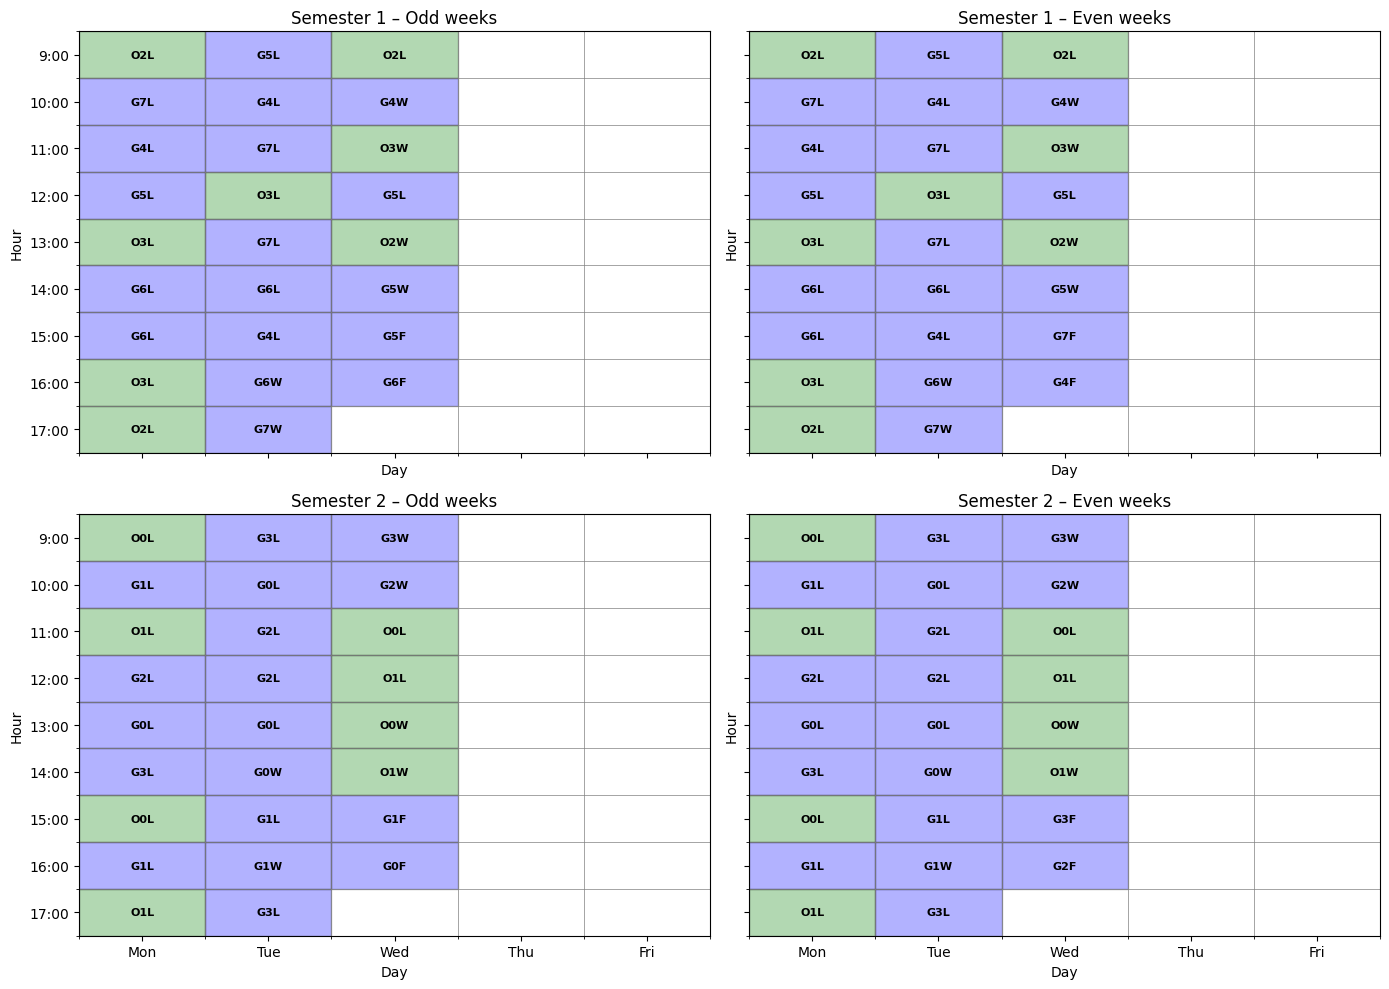

In [19]:
import matplotlib.pyplot as plt
import numpy as np
xL_sol = {k: m.getSolution(v) for k, v in xL.items()}
xW_sol = {k: m.getSolution(v) for k, v in xW.items()}
xF_sol = {k: m.getSolution(v) for k, v in xF.items()}
yL_sol = {k: m.getSolution(v) for k, v in yL.items()}
yW_sol = {k: m.getSolution(v) for k, v in yW.items()}
z_sol  = {k: m.getSolution(v) for k, v in z.items()}
w_sol  = {k: m.getSolution(v) for k, v in w.items()}
    # -------------------------------------------------------------------
    # Visualisation function
    # -------------------------------------------------------------------
def plot_timetable():
        # Create a 2x2 grid: rows = semesters, cols = week parity
        fig, axes = plt.subplots(len(S), len(W), figsize=(14, 10), sharex=True, sharey=True)
        if len(S) == 1 and len(W) == 1:
            axes = np.array([[axes]])
        elif len(S) == 1 or len(W) == 1:
            axes = axes.reshape(len(S), len(W))
        
        day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri'] if num_days == 5 else [f'D{d}' for d in D]
        hour_labels = [f'{9+h}:00' for h in H]  # assuming start at 9am

        for i_s, s in enumerate(S):
            for i_w, w_par in enumerate(W):
                ax = axes[i_s, i_w]
                ax.set_title(f'Semester {s} – {"Odd" if w_par==1 else "Even"} weeks')
                ax.set_xlabel('Day')
                ax.set_ylabel('Hour')
                ax.set_xticks(np.arange(len(D)))
                ax.set_xticklabels(day_labels)
                ax.set_yticks(np.arange(len(H)))
                ax.set_yticklabels(hour_labels)
                ax.set_xlim(-0.5, len(D)-0.5)
                ax.set_ylim(-0.5, len(H)-0.5)
                ax.invert_yaxis()  # so hour 0 (9am) is at top

                # Draw grid lines
                ax.set_xticks(np.arange(-0.5, len(D), 1), minor=True)
                ax.set_yticks(np.arange(-0.5, len(H), 1), minor=True)
                ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

                # Scan all time slots
                for d in D:
                    for h in H:
                        # Collect all events at (d,h,s,w_par)
                        labels = []
                        colors = []
                        # Gateway lectures & weekly workshops (they occur in both weeks)
                        for g in G:
                            if xL_sol.get((g,d,h,s), 0) > 0.5:
                                labels.append(f'G{g}L')
                                colors.append('blue')
                            if xW_sol.get((g,d,h,s), 0) > 0.5:
                                labels.append(f'G{g}W')
                                colors.append('blue')
                            # Fortnightly workshop (depends on w_par)
                            if xF_sol.get((g,d,h,s,w_par), 0) > 0.5:
                                labels.append(f'G{g}F')
                                colors.append('blue')
                        # Optional courses
                        for o in O:
                            if yL_sol.get((o,d,h,s), 0) > 0.5:
                                labels.append(f'O{o}L')
                                colors.append('green')
                            if yW_sol.get((o,d,h,s), 0) > 0.5:
                                labels.append(f'O{o}W')
                                colors.append('green')

                        # If there is an event, draw a coloured rectangle with label
                        if labels:
                            # Combine multiple events (should not happen due to constraint)
                            text = '\n'.join(labels)
                            # Use the color of the first event (all same color if same course type)
                            color = colors[0] if colors else 'gray'
                            rect = plt.Rectangle((d-0.5, h-0.5), 1, 1,
                                                 facecolor=color, alpha=0.3, edgecolor='black')
                            ax.add_patch(rect)
                            ax.text(d, h, text, ha='center', va='center',
                                    fontsize=8, weight='bold')

        plt.tight_layout()
        plt.show()

    # Call the plotting function
plot_timetable()